In [2]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
from dfba import DfbaModel, ExchangeFlux, KineticVariable

model = read_sbml_model('ecYeastGEM.xml')
model.solver = 'glpk'
model.optimize()                               # optimize for biomass growth with standard medium
print(model.objective.value)

0.08797409974594675


1. Make DFBA model

In [3]:
dfba_model = DfbaModel(model)

2. Add kinetic variables for components

In [4]:
X = KineticVariable("Biomass")
Glu = KineticVariable("Glucose")
Xyl = KineticVariable("Xylose")
Xyo = KineticVariable("Xylitol")

dfba_model.add_kinetic_variables([X, Glu, Xyl, Xyo])

3. Add exchange rates

In [5]:
mu = ExchangeFlux("r_2111")
v_G = ExchangeFlux("r_1714")
v_S = ExchangeFlux("r_1718")
v_P = ExchangeFlux("r_2104")


dfba_model.add_exchange_fluxes([mu, v_G, v_S, v_P])

4. Mass balances for batch

In [7]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Xylose", v_S * 150.13/1000 * X)
dfba_model.add_rhs_expression("Xylitol", v_P * 152.15/1000 *X) 

5. Expression bounds

https://link.springer.com/article/10.1007/s00449-007-0169-1
Xylose and Glucose for Hxt1, Xylitol = Xylose due to similar chemical structure (no better values found)

In [8]:
vmax_glu = 7.45 * (1000/180.1559) # [mmol gDW^-1 h^-1]
vmax_xyl = 2.34 * (1000/150.13) # [mmol gDW^-1 h^-1]
vmax_xyo = 2.34 * (1000/152.15) # [mmol gDW^-1 h^-1]

K_glu = 19.8 # g/L Glucose Michaelis-Mentent constant
K_xyl = 132 # g/L Glucose Michaelis-Mentent constant
K_xyo = 132 # g/L Glucose Michaelis-Mentent constant

# lower bound glucose
dfba_model.add_exchange_flux_lb(
    "r_1714",
    vmax_glu * (Glu / (K_glu * (1 + Xyl/K_xyl) + Glu)),
    Glu
)

# lower bound xylose
dfba_model.add_exchange_flux_lb( # glu
    "r_1718",
    vmax_xyl * (Xyl / (K_xyl * (1 + Glu/K_glu) + Xyl)),
    Xyl
)
  
# lower bound xylitol
dfba_model.add_exchange_flux_lb( # glu
    "r_2104",
    vmax_xyo * (Xyo / (K_xyo + Xyo)),
    Xyo
)

6. Initial conditions

In [9]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 5, # (g/L)
        "Xylose": 5,   # (g/L)
        "Xylitol": 0,  # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 25.0, 0.1, ["r_1714", "r_1718", "r_2104"])

7. Plot results

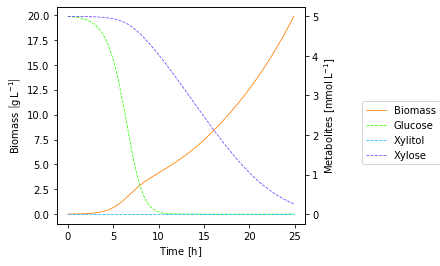

In [10]:
from dfba.plot.matplotlib import *
plot_concentrations(concentrations)